https://qiskit.org/documentation/tutorials/circuits/01_circuit_basics.html

# Configuration

In [5]:
!pip install qiskit-ibm-provider

DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [1]:
from qiskit_ibm_provider import IBMProvider

In [2]:
provider = IBMProvider(token = '8916d1d8c9e6e373407ca4fe61010619f18832bfb2244920b679a8fadeac834cb127fb7b7a0c24c2b4b96b63f6b3a922fe0cfe56337a3cd2f470c2ae08e2554d')

In [3]:
backends = provider.backends()

In [4]:
backends

[<IBMBackend('simulator_mps')>,
 <IBMBackend('simulator_statevector')>,
 <IBMBackend('simulator_stabilizer')>,
 <IBMBackend('ibm_perth')>,
 <IBMBackend('ibm_brisbane')>,
 <IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('ibm_nairobi')>,
 <IBMBackend('ibm_lagos')>]

In [10]:
#backend = provider.get_backend('ibmq_qasm_simulator')
#n_shots = 4000

In [5]:
backend = provider.get_backend('ibm_lagos')

In [6]:
import inspect

def get_default_args(func):
    signature = inspect.signature(func)
    return {
        k: v.default
        for k, v in signature.parameters.items()
        if v.default is not inspect.Parameter.empty
    }

In [7]:
get_default_args(backend.run)

{'dynamic': None,
 'job_tags': None,
 'init_circuit': None,
 'init_num_resets': None,
 'header': None,
 'shots': None,
 'memory': None,
 'meas_level': None,
 'meas_return': None,
 'rep_delay': None,
 'init_qubits': None,
 'use_measure_esp': None,
 'noise_model': None,
 'seed_simulator': None}

In [11]:
config = backend.configuration()

# Basic Features
print("This backend is called {0}, and is on version {1}. It has {2} qubit{3}. It "
      "{4} OpenPulse programs. The basis gates supported on this device are {5}."
      "".format(config.backend_name,
                config.backend_version,
                config.n_qubits,
                '' if config.n_qubits == 1 else 's',
                'supports' if config.open_pulse else 'does not support',
                config.basis_gates))

This backend is called ibmq_qasm_simulator, and is on version 0.1.547. It has 32 qubits. It does not support OpenPulse programs. The basis gates supported on this device are ['u1', 'u2', 'u3', 'u', 'p', 'r', 'rx', 'ry', 'rz', 'id', 'x', 'y', 'z', 'h', 's', 'sdg', 'sx', 't', 'tdg', 'swap', 'cx', 'cy', 'cz', 'csx', 'cp', 'cu1', 'cu2', 'cu3', 'rxx', 'ryy', 'rzz', 'rzx', 'ccx', 'cswap', 'mcx', 'mcy', 'mcz', 'mcsx', 'mcp', 'mcu1', 'mcu2', 'mcu3', 'mcrx', 'mcry', 'mcrz', 'mcr', 'mcswap', 'unitary', 'diagonal', 'multiplexer', 'initialize', 'kraus', 'roerror', 'delay'].


In [8]:
config = backend.configuration()

# Basic Features
print("This backend is called {0}, and is on version {1}. It has {2} qubit{3}. It "
      "{4} OpenPulse programs. The basis gates supported on this device are {5}."
      "".format(config.backend_name,
                config.backend_version,
                config.n_qubits,
                '' if config.n_qubits == 1 else 's',
                'supports' if config.open_pulse else 'does not support',
                config.basis_gates))

This backend is called ibm_lagos, and is on version 1.6.2. It has 7 qubits. It supports OpenPulse programs. The basis gates supported on this device are ['cx', 'id', 'rz', 'sx', 'x'].


# Quantum Eraser

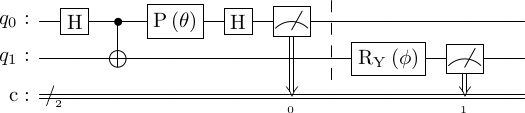

In [9]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.tools.visualization import circuit_drawer
from qiskit.quantum_info import state_fidelity
from qiskit import BasicAer
from qiskit.circuit import Parameter

theta = Parameter('θ')
phi = Parameter('ϕ')

qc = QuantumCircuit(2, 2)

# Bell pair
qc.h(0)
qc.cx(0,1)

# phase for path difference
qc.p(theta, 0)

# combine two path
qc.h(0)

# measure 
qc.measure(0, 0)
qc.barrier()

# erase or not
qc.ry(phi, 1)
qc.measure(1, 1)

qc.draw('latex', style='iqp')

In [10]:
import numpy as np

theta_range = np.linspace(-5 * np.pi, 5 * np.pi, 128)
n_shots = 1024 # default value

#backend = BasicAer.get_backend('qasm_simulator')

circuits = [qc.assign_parameters({theta: theta_val, phi: 0})
            for theta_val in theta_range]
job = backend.run(transpile(circuits, backend), shots=n_shots)
print('job done')

counts = job.result().get_counts()

circuits = [qc.assign_parameters({theta: theta_val, phi: np.pi/2})
            for theta_val in theta_range]
job = backend.run(transpile(circuits, backend), shots=n_shots)
print('job done')

counts2 = job.result().get_counts()


In [12]:
x = list(map(lambda c: (c.get('00', 0)+c.get('11', 0))/n_shots, counts))
x_erase = list(map(lambda c: (c.get('00',0)+c.get('11', 0))/n_shots, counts2))

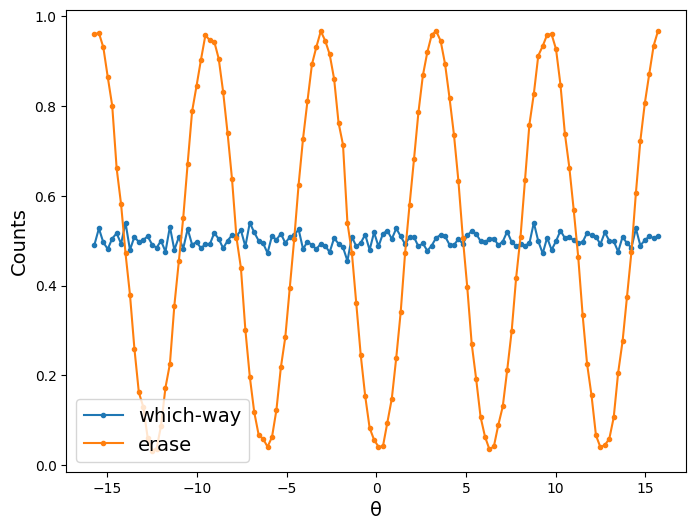

In [13]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.plot(theta_range, x, '.-', label='which-way')
ax.plot(theta_range, x_erase, '.-', label='erase')

#ax.set_xticks([i * np.pi / 2 for i in range(5)])
#ax.set_xticklabels(['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$'], fontsize=14)
ax.set_xlabel('θ', fontsize=14)
ax.set_ylabel('Counts', fontsize=14)
ax.legend(fontsize=14)
plt.show()

In [14]:
counts

[{'01': 269, '00': 235, '11': 268, '10': 252},
 {'01': 251, '00': 279, '10': 233, '11': 261},
 {'01': 267, '00': 252, '10': 249, '11': 256},
 {'01': 282, '00': 243, '10': 249, '11': 250},
 {'01': 247, '00': 232, '11': 285, '10': 260},
 {'01': 245, '00': 250, '10': 250, '11': 279},
 {'01': 274, '00': 244, '10': 245, '11': 261},
 {'01': 247, '00': 261, '11': 292, '10': 224},
 {'01': 270, '00': 255, '10': 263, '11': 236},
 {'01': 264, '00': 274, '11': 247, '10': 239},
 {'01': 272, '00': 248, '10': 243, '11': 261},
 {'01': 249, '00': 258, '11': 256, '10': 261},
 {'01': 241, '00': 270, '10': 261, '11': 252},
 {'01': 262, '00': 252, '11': 251, '10': 259},
 {'01': 254, '00': 244, '10': 274, '11': 252},
 {'01': 261, '00': 283, '10': 251, '11': 229},
 {'01': 275, '00': 227, '10': 262, '11': 260},
 {'01': 234, '00': 285, '10': 246, '11': 259},
 {'01': 254, '00': 241, '10': 279, '11': 250},
 {'01': 241, '00': 255, '11': 265, '10': 263},
 {'01': 255, '00': 233, '10': 275, '11': 261},
 {'01': 247, 

In [15]:
counts2

[{'00': 485, '10': 26, '01': 15, '11': 498},
 {'00': 455, '10': 13, '01': 25, '11': 531},
 {'00': 446, '10': 26, '01': 45, '11': 507},
 {'00': 419, '10': 51, '01': 88, '11': 466},
 {'00': 410, '10': 99, '01': 105, '11': 410},
 {'00': 354, '10': 163, '01': 184, '11': 323},
 {'00': 313, '10': 193, '01': 236, '11': 282},
 {'00': 259, '10': 240, '01': 301, '11': 224},
 {'00': 211, '10': 303, '01': 332, '11': 178},
 {'00': 140, '10': 352, '01': 406, '11': 126},
 {'00': 96, '10': 421, '01': 437, '11': 70},
 {'00': 69, '10': 435, '01': 456, '11': 64},
 {'00': 32, '10': 494, '01': 468, '11': 30},
 {'00': 19, '10': 497, '01': 494, '11': 14},
 {'00': 15, '10': 513, '01': 473, '11': 23},
 {'00': 38, '10': 468, '01': 466, '11': 52},
 {'00': 71, '10': 445, '01': 402, '11': 106},
 {'00': 101, '10': 424, '01': 369, '11': 130},
 {'00': 165, '10': 340, '01': 320, '11': 199},
 {'00': 193, '10': 306, '01': 253, '11': 272},
 {'00': 266, '10': 248, '01': 212, '11': 298},
 {'00': 307, '10': 199, '01': 137, 

In [17]:
# actual results from IBM quantum computer ibm_lagos
counts = \
[{'01': 269, '00': 235, '11': 268, '10': 252},
 {'01': 251, '00': 279, '10': 233, '11': 261},
 {'01': 267, '00': 252, '10': 249, '11': 256},
 {'01': 282, '00': 243, '10': 249, '11': 250},
 {'01': 247, '00': 232, '11': 285, '10': 260},
 {'01': 245, '00': 250, '10': 250, '11': 279},
 {'01': 274, '00': 244, '10': 245, '11': 261},
 {'01': 247, '00': 261, '11': 292, '10': 224},
 {'01': 270, '00': 255, '10': 263, '11': 236},
 {'01': 264, '00': 274, '11': 247, '10': 239},
 {'01': 272, '00': 248, '10': 243, '11': 261},
 {'01': 249, '00': 258, '11': 256, '10': 261},
 {'01': 241, '00': 270, '10': 261, '11': 252},
 {'01': 262, '00': 252, '11': 251, '10': 259},
 {'01': 254, '00': 244, '10': 274, '11': 252},
 {'01': 261, '00': 283, '10': 251, '11': 229},
 {'01': 275, '00': 227, '10': 262, '11': 260},
 {'01': 234, '00': 285, '10': 246, '11': 259},
 {'01': 254, '00': 241, '10': 279, '11': 250},
 {'01': 241, '00': 255, '11': 265, '10': 263},
 {'01': 255, '00': 233, '10': 275, '11': 261},
 {'01': 247, '00': 272, '10': 238, '11': 267},
 {'01': 271, '00': 267, '11': 236, '10': 250},
 {'01': 269, '00': 265, '10': 246, '11': 244},
 {'01': 272, '00': 258, '11': 237, '10': 257},
 {'01': 284, '00': 254, '11': 250, '10': 236},
 {'01': 255, '00': 248, '11': 256, '10': 265},
 {'01': 242, '00': 280, '11': 250, '10': 252},
 {'01': 249, '00': 235, '11': 281, '10': 259},
 {'01': 271, '00': 236, '11': 259, '10': 258},
 {'01': 268, '00': 234, '10': 244, '11': 278},
 {'01': 265, '00': 234, '11': 291, '10': 234},
 {'01': 241, '00': 270, '11': 252, '10': 261},
 {'01': 251, '00': 248, '10': 237, '11': 288},
 {'01': 272, '00': 236, '11': 263, '10': 253},
 {'01': 251, '00': 263, '11': 290, '10': 220},
 {'01': 257, '00': 264, '11': 267, '10': 236},
 {'01': 254, '00': 282, '10': 258, '11': 230},
 {'01': 236, '00': 264, '11': 242, '10': 282},
 {'01': 263, '00': 247, '10': 277, '11': 237},
 {'01': 259, '00': 255, '10': 242, '11': 268},
 {'01': 248, '00': 263, '11': 251, '10': 262},
 {'01': 238, '00': 256, '10': 258, '11': 272},
 {'01': 250, '00': 235, '10': 267, '11': 272},
 {'01': 273, '00': 257, '10': 231, '11': 263},
 {'01': 266, '00': 253, '11': 271, '10': 234},
 {'01': 238, '00': 266, '11': 272, '10': 248},
 {'01': 266, '00': 267, '10': 265, '11': 226},
 {'01': 262, '00': 262, '10': 252, '11': 248},
 {'01': 268, '00': 260, '10': 254, '11': 242},
 {'01': 284, '00': 238, '11': 255, '10': 247},
 {'01': 250, '00': 238, '10': 269, '11': 267},
 {'01': 272, '00': 262, '10': 252, '11': 238},
 {'01': 286, '00': 237, '11': 249, '10': 252},
 {'01': 250, '00': 264, '10': 256, '11': 254},
 {'01': 265, '00': 250, '11': 255, '10': 254},
 {'01': 269, '00': 239, '10': 258, '11': 258},
 {'01': 297, '00': 236, '10': 261, '11': 230},
 {'01': 214, '00': 263, '11': 258, '10': 289},
 {'01': 256, '00': 255, '10': 269, '11': 244},
 {'01': 238, '00': 241, '10': 279, '11': 266},
 {'01': 231, '00': 285, '10': 267, '11': 241},
 {'01': 277, '00': 253, '10': 256, '11': 238},
 {'01': 258, '00': 263, '11': 268, '10': 235},
 {'01': 247, '00': 249, '10': 278, '11': 250},
 {'01': 242, '00': 278, '11': 250, '10': 254},
 {'01': 261, '00': 274, '10': 228, '11': 261},
 {'01': 261, '00': 264, '11': 252, '10': 247},
 {'01': 243, '00': 254, '11': 286, '10': 241},
 {'01': 257, '00': 268, '10': 245, '11': 254},
 {'01': 267, '00': 250, '10': 253, '11': 254},
 {'01': 282, '00': 263, '11': 257, '10': 222},
 {'01': 260, '00': 265, '10': 244, '11': 255},
 {'01': 261, '00': 237, '11': 262, '10': 264},
 {'01': 299, '00': 271, '11': 235, '10': 219},
 {'01': 262, '00': 236, '10': 273, '11': 253},
 {'01': 277, '00': 230, '11': 271, '10': 246},
 {'01': 243, '00': 257, '10': 262, '11': 262},
 {'01': 254, '00': 238, '11': 287, '10': 245},
 {'01': 251, '00': 265, '11': 257, '10': 251},
 {'01': 269, '00': 249, '10': 252, '11': 254},
 {'01': 252, '00': 255, '11': 247, '10': 270},
 {'01': 271, '00': 250, '11': 266, '10': 237},
 {'01': 269, '00': 265, '11': 240, '10': 250},
 {'01': 247, '00': 269, '11': 255, '10': 253},
 {'01': 245, '00': 269, '11': 265, '10': 245},
 {'01': 253, '00': 274, '10': 243, '11': 254},
 {'01': 251, '00': 255, '11': 256, '10': 262},
 {'01': 252, '00': 261, '11': 247, '10': 264},
 {'01': 248, '00': 268, '11': 249, '10': 259},
 {'01': 233, '00': 240, '11': 277, '10': 274},
 {'01': 259, '00': 272, '11': 230, '10': 263},
 {'01': 250, '00': 267, '10': 264, '11': 243},
 {'01': 234, '00': 279, '11': 254, '10': 257},
 {'01': 273, '00': 250, '10': 242, '11': 259},
 {'01': 256, '00': 257, '11': 243, '10': 268},
 {'01': 256, '00': 273, '11': 231, '10': 264},
 {'01': 251, '00': 273, '10': 272, '11': 228},
 {'01': 263, '00': 250, '11': 256, '10': 255},
 {'01': 244, '00': 276, '11': 277, '10': 227},
 {'01': 249, '00': 251, '11': 260, '10': 264},
 {'01': 266, '00': 250, '10': 275, '11': 233},
 {'01': 260, '00': 248, '11': 271, '10': 245},
 {'01': 263, '00': 248, '11': 243, '10': 270},
 {'01': 267, '00': 241, '11': 270, '10': 246},
 {'01': 255, '00': 248, '11': 287, '10': 234},
 {'01': 264, '00': 250, '11': 268, '10': 242},
 {'01': 259, '00': 268, '10': 245, '11': 252},
 {'01': 258, '00': 252, '11': 261, '10': 253},
 {'01': 248, '00': 230, '10': 269, '11': 277},
 {'01': 245, '00': 253, '10': 270, '11': 256},
 {'01': 241, '00': 261, '11': 269, '10': 253},
 {'01': 254, '00': 270, '10': 246, '11': 254},
 {'01': 250, '00': 278, '11': 243, '10': 253},
 {'01': 250, '00': 265, '10': 270, '11': 239},
 {'01': 237, '00': 272, '11': 259, '10': 256},
 {'01': 252, '00': 263, '11': 249, '10': 260},
 {'01': 250, '00': 260, '10': 263, '11': 251},
 {'01': 267, '00': 238, '10': 270, '11': 249},
 {'01': 263, '00': 266, '10': 240, '11': 255},
 {'01': 250, '00': 251, '10': 268, '11': 255},
 {'01': 288, '00': 247, '11': 249, '10': 240},
 {'01': 248, '00': 273, '10': 236, '11': 267},
 {'01': 281, '00': 249, '11': 252, '10': 242},
 {'01': 251, '00': 248, '11': 265, '10': 260},
 {'01': 278, '00': 248, '11': 274, '10': 224},
 {'01': 257, '00': 256, '11': 262, '10': 249},
 {'01': 253, '00': 255, '10': 248, '11': 268}]

In [18]:
counts2 = \
[{'00': 485, '10': 26, '01': 15, '11': 498},
 {'00': 455, '10': 13, '01': 25, '11': 531},
 {'00': 446, '10': 26, '01': 45, '11': 507},
 {'00': 419, '10': 51, '01': 88, '11': 466},
 {'00': 410, '10': 99, '01': 105, '11': 410},
 {'00': 354, '10': 163, '01': 184, '11': 323},
 {'00': 313, '10': 193, '01': 236, '11': 282},
 {'00': 259, '10': 240, '01': 301, '11': 224},
 {'00': 211, '10': 303, '01': 332, '11': 178},
 {'00': 140, '10': 352, '01': 406, '11': 126},
 {'00': 96, '10': 421, '01': 437, '11': 70},
 {'00': 69, '10': 435, '01': 456, '11': 64},
 {'00': 32, '10': 494, '01': 468, '11': 30},
 {'00': 19, '10': 497, '01': 494, '11': 14},
 {'00': 15, '10': 513, '01': 473, '11': 23},
 {'00': 38, '10': 468, '01': 466, '11': 52},
 {'00': 71, '10': 445, '01': 402, '11': 106},
 {'00': 101, '10': 424, '01': 369, '11': 130},
 {'00': 165, '10': 340, '01': 320, '11': 199},
 {'00': 193, '10': 306, '01': 253, '11': 272},
 {'00': 266, '10': 248, '01': 212, '11': 298},
 {'00': 307, '10': 199, '01': 137, '11': 381},
 {'00': 376, '10': 115, '01': 102, '11': 431},
 {'00': 425, '10': 106, '01': 53, '11': 440},
 {'00': 430, '10': 65, '01': 34, '11': 495},
 {'00': 461, '10': 28, '01': 15, '11': 520},
 {'00': 474, '10': 31, '01': 24, '11': 495},
 {'00': 468, '10': 25, '01': 33, '11': 498},
 {'00': 447, '10': 42, '01': 55, '11': 480},
 {'00': 433, '10': 75, '01': 98, '11': 418},
 {'00': 381, '10': 128, '01': 139, '11': 376},
 {'00': 330, '10': 180, '01': 192, '11': 322},
 {'00': 287, '10': 246, '01': 259, '11': 232},
 {'00': 235, '10': 288, '01': 286, '11': 215},
 {'00': 166, '10': 335, '01': 380, '11': 143},
 {'00': 114, '10': 371, '01': 451, '11': 88},
 {'00': 64, '10': 450, '01': 453, '11': 57},
 {'00': 46, '10': 471, '01': 484, '11': 23},
 {'00': 29, '10': 488, '01': 476, '11': 31},
 {'00': 17, '10': 493, '01': 489, '11': 25},
 {'00': 23, '10': 510, '01': 450, '11': 41},
 {'00': 45, '10': 473, '01': 425, '11': 81},
 {'00': 95, '10': 432, '01': 369, '11': 128},
 {'00': 128, '10': 387, '01': 345, '11': 164},
 {'00': 178, '10': 331, '01': 289, '11': 226},
 {'00': 237, '10': 291, '01': 218, '11': 278},
 {'00': 301, '10': 193, '01': 191, '11': 339},
 {'00': 353, '10': 155, '01': 124, '11': 392},
 {'00': 409, '10': 110, '01': 83, '11': 422},
 {'00': 461, '10': 67, '01': 43, '11': 453},
 {'00': 469, '10': 45, '01': 25, '11': 485},
 {'00': 499, '10': 18, '01': 16, '11': 491},
 {'00': 511, '10': 27, '01': 29, '11': 457},
 {'00': 506, '10': 37, '01': 50, '11': 431},
 {'00': 445, '10': 52, '01': 91, '11': 436},
 {'00': 407, '10': 110, '01': 133, '11': 374},
 {'00': 368, '10': 128, '01': 165, '11': 363},
 {'00': 288, '10': 218, '01': 253, '11': 265},
 {'00': 256, '10': 250, '01': 289, '11': 229},
 {'00': 208, '10': 326, '01': 329, '11': 161},
 {'00': 141, '10': 398, '01': 375, '11': 110},
 {'00': 91, '10': 430, '01': 436, '11': 67},
 {'00': 55, '10': 477, '01': 462, '11': 30},
 {'00': 38, '10': 485, '01': 481, '11': 20},
 {'00': 20, '10': 477, '01': 505, '11': 22},
 {'00': 21, '10': 517, '01': 464, '11': 22},
 {'00': 32, '10': 483, '01': 444, '11': 65},
 {'00': 62, '10': 450, '01': 422, '11': 90},
 {'00': 92, '10': 381, '01': 398, '11': 153},
 {'00': 166, '10': 376, '01': 299, '11': 183},
 {'00': 217, '10': 319, '01': 220, '11': 268},
 {'00': 268, '10': 225, '01': 205, '11': 326},
 {'00': 290, '10': 181, '01': 145, '11': 408},
 {'00': 394, '10': 129, '01': 90, '11': 411},
 {'00': 410, '10': 88, '01': 47, '11': 479},
 {'00': 454, '10': 54, '01': 28, '11': 488},
 {'00': 469, '10': 26, '01': 16, '11': 513},
 {'00': 507, '10': 20, '01': 14, '11': 483},
 {'00': 457, '10': 18, '01': 38, '11': 511},
 {'00': 473, '10': 45, '01': 64, '11': 442},
 {'00': 413, '10': 77, '01': 109, '11': 425},
 {'00': 376, '10': 102, '01': 168, '11': 378},
 {'00': 340, '10': 173, '01': 202, '11': 309},
 {'00': 260, '10': 223, '01': 282, '11': 259},
 {'00': 221, '10': 299, '01': 319, '11': 185},
 {'00': 169, '10': 347, '01': 400, '11': 108},
 {'00': 107, '10': 400, '01': 427, '11': 90},
 {'00': 66, '10': 438, '01': 476, '11': 44},
 {'00': 32, '10': 514, '01': 445, '11': 33},
 {'00': 24, '10': 522, '01': 466, '11': 12},
 {'00': 14, '10': 501, '01': 480, '11': 29},
 {'00': 37, '10': 485, '01': 447, '11': 55},
 {'00': 60, '10': 463, '01': 427, '11': 74},
 {'00': 105, '10': 433, '01': 374, '11': 112},
 {'00': 136, '10': 386, '01': 333, '11': 169},
 {'00': 192, '10': 333, '01': 265, '11': 234},
 {'00': 254, '10': 260, '01': 243, '11': 267},
 {'00': 289, '10': 208, '01': 166, '11': 361},
 {'00': 370, '10': 132, '01': 115, '11': 407},
 {'00': 423, '10': 110, '01': 67, '11': 424},
 {'00': 437, '10': 62, '01': 28, '11': 497},
 {'00': 464, '10': 33, '01': 35, '11': 492},
 {'00': 476, '10': 19, '01': 23, '11': 506},
 {'00': 476, '10': 13, '01': 28, '11': 507},
 {'00': 465, '10': 28, '01': 47, '11': 484},
 {'00': 449, '10': 66, '01': 90, '11': 419},
 {'00': 414, '10': 121, '01': 147, '11': 342},
 {'00': 346, '10': 159, '01': 186, '11': 333},
 {'00': 309, '10': 206, '01': 237, '11': 272},
 {'00': 260, '10': 255, '01': 294, '11': 215},
 {'00': 189, '10': 346, '01': 336, '11': 153},
 {'00': 125, '10': 370, '01': 423, '11': 106},
 {'00': 102, '10': 419, '01': 446, '11': 57},
 {'00': 39, '10': 470, '01': 486, '11': 29},
 {'00': 24, '10': 509, '01': 474, '11': 17},
 {'00': 23, '10': 493, '01': 485, '11': 23},
 {'00': 21, '10': 492, '01': 472, '11': 39},
 {'00': 49, '10': 488, '01': 427, '11': 60},
 {'00': 97, '10': 423, '01': 390, '11': 114},
 {'00': 114, '10': 419, '01': 322, '11': 169},
 {'00': 158, '10': 337, '01': 303, '11': 226},
 {'00': 239, '10': 279, '01': 258, '11': 248},
 {'00': 282, '10': 213, '01': 190, '11': 339},
 {'00': 362, '10': 162, '01': 122, '11': 378},
 {'00': 393, '10': 126, '01': 73, '11': 432},
 {'00': 432, '10': 85, '01': 47, '11': 460},
 {'00': 452, '10': 43, '01': 24, '11': 505},
 {'00': 480, '10': 14, '01': 19, '11': 511}]